In [1]:
# import base64
# import imageio
from env.TFenv import HangmanEnvironment

import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf

from tf_agents.agents.dqn.dqn_agent import DqnAgent, DdqnAgent
from tf_agents.networks.q_network import QNetwork
from tf_agents.networks.q_network import QNetwork

 
from tf_agents.environments import suite_gym


from tf_agents.environments import tf_py_environment

from tf_agents.policies.random_tf_policy import RandomTFPolicy
from tf_agents.replay_buffers.tf_uniform_replay_buffer import TFUniformReplayBuffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common
from multiprocessing import Pool



In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# print(device_lib.list_local_devices())


Num GPUs Available:  0


In [11]:
# Globals
NUMBER_EPOSODES = 50000
COLLECTION_STEPS = 1
BATCH_SIZE = 64
EVAL_EPISODES = 30
EVAL_INTERVAL = 1000

dictionary_path = "../../../properties/words_250000_train.txt"
reward_map = {
    "game_success_reward": 2.00,
    "lose_reward": -0.010,
    "guess_success_reward": 0.2,
    "guess_fail_reward": -0.0001,
    "guess_repeat_reward": -0.05,
}
life_initial = 15

train_env = HangmanEnvironment(dictionary_path, reward_map,life_initial)
evaluation_env = HangmanEnvironment(dictionary_path, reward_map,life_initial)

print('Observation Spec:')
print(train_env.time_step_spec().observation)

print('Reward Spec:')
print(train_env.time_step_spec().reward)

print('Action Spec:')
print(train_env.action_spec())

train_env = tf_py_environment.TFPyEnvironment(train_env)
evaluation_env = tf_py_environment.TFPyEnvironment(evaluation_env)




Observation Spec:
BoundedArraySpec(shape=(1, 30), dtype=dtype('int32'), name='game', minimum=-1, maximum=26)
Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')
Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int32'), name='letter', minimum=0, maximum=25)


In [5]:
# train_env.action_spec()
train_env.time_step_spec()
log_interval = 200

In [6]:

# hidden_layers = (512, 4)
# lstm_size = 
# # (100,)

# critic_rnn_network = CriticRnnNetwork(
#     train_env.observation_spec(),
#     train_env.action_spec(),
#     action_fc_layer_params=hidden_layers,
#     joint_fc_layer_params=hidden_layers,
#     lstm_size=(256, 256)
#     )



# counter = tf.Variable(0)

# ddqn_agent = DdqnAgent(
#     train_env.time_step_spec(),
#     train_env.action_spec(),
#     q_network = ddqn_network,
#     optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=1e-3),
#     td_errors_loss_fn = common.element_wise_squared_loss,
#     train_step_counter = counter)

# ddqn_agent.initialize()

In [3]:
from tf_agents.agents.ddpg import actor_rnn_network
from tf_agents.agents.ddpg import critic_rnn_network
from tf_agents.agents.td3 import td3_agent
from tf_agents.drivers import dynamic_episode_driver


actor_learning_rate=1e-3
critic_learning_rate=1e-3

actor_net = actor_rnn_network.ActorRnnNetwork(
    train_env.time_step_spec().observation,
    train_env.action_spec(),
    input_fc_layer_params=(256,),
    lstm_size=(256,),
    output_fc_layer_params=(256,))

critic_net_input_specs = (train_env.time_step_spec().observation,
                          train_env.action_spec())

critic_net = critic_rnn_network.CriticRnnNetwork(
    critic_net_input_specs,
    observation_fc_layer_params=None,
    action_fc_layer_params=None,
    joint_fc_layer_params=(256,),
    lstm_size=(256,),
    output_fc_layer_params=(256,))

global_step = tf.compat.v1.train.get_or_create_global_step()

tf_agent = td3_agent.Td3Agent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    actor_network=actor_net,
    critic_network=critic_net,
    actor_optimizer=tf.compat.v1.train.AdamOptimizer(
        learning_rate=actor_learning_rate),
    critic_optimizer=tf.compat.v1.train.AdamOptimizer(
        learning_rate=critic_learning_rate),
    # exploration_noise_std=exploration_noise_std,
    # target_update_tau=target_update_tau,
    # target_update_period=target_update_period,
    # actor_update_period=actor_update_period,
    # dqda_clipping=dqda_clipping,
    # td_errors_loss_fn=td_errors_loss_fn,
    # gamma=gamma,
    # reward_scale_factor=reward_scale_factor,
    # gradient_clipping=gradient_clipping,
    # train_step_counter=global_step
    )
tf_agent.initialize()

eval_policy = tf_agent.policy
collect_policy = tf_agent.collect_policy

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)

initial_collect_driver = dynamic_episode_driver.DynamicStepDriver(
        train_env,
        collect_policy,
        observers=[replay_buffer.add_batch],
        num_steps=initial_collect_steps)
initial_collect_driver.run = common.function(initial_collect_driver.run)
initial_collect_driver.run()


NameError: name 'actor_rnn_network' is not defined

In [7]:

def get_average_reward(environment, policy, episodes=10):

    total_reward = 0.0

    for _ in range(episodes):
        time_step = environment.reset()
        episode_reward = 0.0

        while not time_step.is_last():
        # for _ in range(4):
            action_step = policy.action(time_step)
            # print(action_step.action)
            time_step = environment.step(action_step.action)
            episode_reward += time_step.reward
            # print(time_step.is_last())
    
        total_reward += episode_reward
        avg_reward = total_reward / episodes
    
    return avg_reward.numpy()[0]

class ExperienceReplay(object):
    def __init__(self, agent, enviroment):
        self._replay_buffer = TFUniformReplayBuffer(
            data_spec=agent.collect_data_spec,
            batch_size=enviroment.batch_size,
            max_length=50000)
        
        self._random_policy = RandomTFPolicy(train_env.time_step_spec(),
                                                enviroment.action_spec())
        
        self._fill_buffer(train_env, self._random_policy, steps=100)
        
        self.dataset = self._replay_buffer.as_dataset(
            num_parallel_calls=3, 
            sample_batch_size=BATCH_SIZE, 
            num_steps=2).prefetch(3)

        self.iterator = iter(self.dataset)
    
    def _fill_buffer(self, enviroment, policy, steps):
        for _ in range(steps):
            self.timestamp_data(enviroment, policy)
            
    def timestamp_data(self, environment, policy):
        time_step = environment.current_time_step()
        action_step = policy.action(time_step)
        next_time_step = environment.step(action_step.action)
        timestamp_trajectory = trajectory.from_transition(time_step, action_step, next_time_step)

        self._replay_buffer.add_batch(timestamp_trajectory)




In [8]:
# print(time_step.is_last())
# action_step.action
# time_step = evaluation_env.step(action_step.action)
# time_step.reward
# print(time_step.is_last())

In [9]:

# total_reward = 0.0
# episodes=10

# for _ in range(episodes):
#     time_step = evaluation_env.reset()
#     episode_reward = 0.0

#     while not time_step.is_last():
#     # for _ in range(4):
#         action_step = ddqn_agent.policy.action(time_step)
#         print(chr(int(action_step.action.numpy()) + 97))
#         time_step = evaluation_env.step(action_step.action)
#         print("".join([chr(int(x) + 97) for x in time_step[3].numpy()[0][0]]))
#         episode_reward += time_step.reward
#         # print(time_step)

#     total_reward += episode_reward
#     avg_reward = total_reward / episodes
    


In [10]:
print("**********************************")
print("Training DDQN")
print("**********************************")

# def train(agent):
experience_replay = ExperienceReplay(ddqn_agent, train_env)
ddqn_agent.train_step_counter.assign(0)
print("before avg reward")

avg_reward = get_average_reward(evaluation_env, ddqn_agent.policy, EVAL_EPISODES)
print("before iter")
rewards = [avg_reward]
print("before iter")

for _ in range(NUMBER_EPOSODES):
    for _ in range(COLLECTION_STEPS):
        experience_replay.timestamp_data(train_env, ddqn_agent.collect_policy)

    experience, info = next(experience_replay.iterator)
    train_loss = ddqn_agent.train(experience).loss
    # print(f"ddqn_agent: {_}")
    if ddqn_agent.train_step_counter.numpy() % 500 == 0:
        print(ddqn_agent.train_step_counter.numpy())
    if ddqn_agent.train_step_counter.numpy() % EVAL_INTERVAL == 0:
        avg_reward = get_average_reward(evaluation_env, ddqn_agent.policy, EVAL_EPISODES)
        print('Episode {0} - Average reward = {1}, Loss = {2}.'.format(
                ddqn_agent.train_step_counter.numpy(), avg_reward, train_loss))
        rewards.append(avg_reward)
            
    # return rewards, agent, experience_replay

# print("**********************************")
# print("Training DQN")
# print("**********************************")
# dqn_reward = train(dqn_agent)

print("**********************************")
print("DONE")
print("**********************************")
# ddqn_reward, agent = train(ddqn_agent)


**********************************
Training DDQN
**********************************
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.
before avg reward
before iter
before iter
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
100
200
300
400
500
600
700
800
900
1000
Episode 1000 - Average reward = -6.647332668304443, Loss = 0.15687662363052368.
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
Episode 2000 - Average reward = -6.610964775085449, Los

KeyboardInterrupt: 

In [11]:
# # train_env.render()
import logging
logging.basicConfig(format='%(levelname)s:%(message)s',
                    level=logging.DEBUG)
ddqn_agent.train_step_counter.numpy()
# time_step = train_env.current_time_step()
# print(time_step)
# print("".join([chr(int(x)+97) for x in time_step[3][0][0]]).replace("{",".").replace('`',""))

# action_step = ddqn_agent.policy.action(time_step)
# action_step

50000

(-2.0, 1.0)

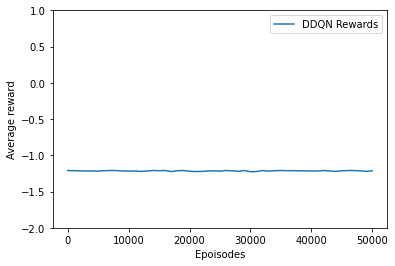

In [18]:
episodes = range(0, NUMBER_EPOSODES + 1, EVAL_INTERVAL)
plt.plot(episodes, rewards, label = 'DDQN Rewards')
plt.legend()
plt.ylabel('Average reward')
plt.xlabel('Epoisodes')
plt.ylim(top=1, bottom=-2)


In [ ]:
# # save policy
# PolicySaver(eval_policy).save(model_dir + 'eval_policy')
# ...
# # load policy
# policy = tf.saved_model.load(model_path)
# action = policy.action(timestep)


In [ ]:
tempdir = os.getenv("TEST_TMPDIR", tempfile.gettempdir())
checkpoint_dir = os.path.join(tempdir, 'checkpoint')
train_checkpointer = common.Checkpointer(
    ckpt_dir=checkpoint_dir,
    max_to_keep=1,
    agent=agent,
    policy=agent.policy,
    replay_buffer=ExperienceReplay,
)
train_checkpointer.save()



In [ ]:
policy_dir = os.path.join(tempdir, 'policy')
tf_policy_saver = policy_saver.PolicySaver(agent.policy)
tf_policy_saver.save(policy_dir)
